In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import tensorflow as tf
import itertools
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.regularizers import L2
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN

## Dataset uploading 

In [2]:
test_data = pd.read_csv("mitbih_test.csv", header=None)
train_data = pd.read_csv("mitbih_train.csv", header=None)

In [3]:
tf.debugging.set_log_device_placement(True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Visualising the distribution of the dataset 

C:\Users\Miłosz\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


87554

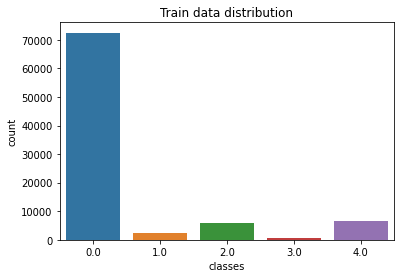

In [4]:
train_data = train_data.rename(columns={187: 'classes'})
sns.countplot(train_data['classes'], label='count of individual classes').set(title='Train data distribution')
train_data['classes'].value_counts()
len(train_data['classes'])

C:\Users\Miłosz\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: classes, dtype: int64

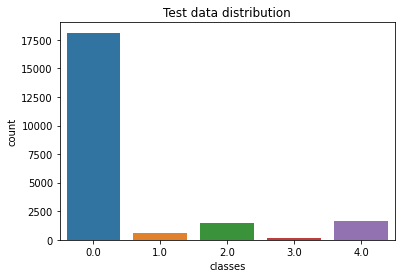

In [5]:
test_data = test_data.rename(columns={187: 'classes'})
sns.countplot(test_data['classes'], label='count of individual classes').set(title='Test data distribution')
test_data['classes'].value_counts()

## Building the convolution neural network 

In [6]:
class ConvNN(object):
    def __init__(self, train_data = None, validation_data = None, batchsize=64,
                 epochs=20, learning_rate=1e-4, filepath = None,
                 dropout_rate=0.5, random_seed=None):
        self.train_data = train_data
        self.validation_data = validation_data
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.filepath = filepath
            
                
    def train(self):

        inputs = Input(shape=((187, 1)), name='inputs_cnn')
        self.train_data[0] = self.train_data[0].reshape(len(self.train_data[0]), 187, 1)
        self.validation_data[0] = self.validation_data[0].reshape(len(self.validation_data[0]), 187, 1)

        ## First layer: splot_1
        h1 = Convolution1D(kernel_size=(5), 
                            filters=64, 
                            kernel_regularizer=L2(l=0.01),
                            activation='relu')(inputs)
        ## Max pooling layer 
        h1_pool = MaxPool1D(pool_size=(5), 
                            strides=(2),
                            padding='same')(h1)
        ## Second layer: splot_2
        h2 = Convolution1D(kernel_size=(5), 
                            filters=64, 
                            kernel_regularizer=L2(l=0.01),
                            activation='relu')(h1_pool)
        ## Max pooling layer
        h2_pool = MaxPool1D(pool_size=(5), 
                            strides=(2),
                            padding='same')(h2)
        ## Thrid layer: splot_3
        h3 = Convolution1D(kernel_size=(5), 
                            filters=64, 
                            kernel_regularizer=L2(l=0.01),
                            activation='relu')(h2_pool)
        ## Max pooling layer
        h3_pool = MaxPool1D(pool_size=(5), 
                            strides=(2),
                            padding='same')(h3)


        ## Fourth and fifth layer: fully connected 
        flatted_h4_pool = Flatten()(h3_pool)
        h4 = Dense(units=256, activation='relu')(flatted_h4_pool)
        h5 = Dense(units=128, activation='relu')(h4)

        ## Dropout
        drop = Dropout(rate=self.dropout_rate)
        h5_drop = drop(h5, training = True)

        ## Sixth layer: fully connected 
        h6 = Dense(5, activation='Softmax', name='output')(h5_drop)

        model = Model(inputs=inputs, outputs=h6)

        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate,
                                beta_1 = 0.9, beta_2 = 0.999)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        my_callbacks = [     
            tf.keras.callbacks.ModelCheckpoint(self.filepath, save_best_only=True, monitor='val_accuracy'),
            tf.keras.callbacks.EarlyStopping(patience=5),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)
        ]

        history = model.fit(self.train_data[0], self.train_data[1],
        batch_size=self.batchsize, epochs=self.epochs,
        validation_data=tuple(self.validation_data),
        callbacks=my_callbacks)

        return model, history

## Making X and y sets 

In [7]:
y_train = train_data['classes'].astype(int)
X_train = train_data.drop(columns=['classes'])

y_test = test_data['classes'].astype(int)
X_test = test_data.drop(columns=['classes'])

## Oversampling the data by ADASYN algorithm  

In [8]:
y_values = y_train.values
dict_classes1 = {1: np.sum(y_values==1)*8, 
                2: np.sum(y_values==2)*8, 
                3: np.sum(y_values==3)*8, 
                4: np.sum(y_values==4)*8}

X_train_ovr, y_train_ovr = ADASYN(sampling_strategy=dict_classes1, random_state=0).fit_resample(X_train, y_train)

## Visualising the distribution of the oversampled dataset 

C:\Users\Miłosz\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    72471
4    51406
2    46010
1    17957
3     5114
Name: classes, dtype: int64

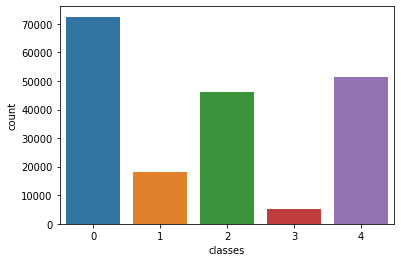

In [9]:
train_data_ovr = pd.concat([X_train_ovr, y_train_ovr], axis=1)
sns.countplot(train_data_ovr['classes'], label='count of individual classes after oversampling').set(title='')
train_data_ovr['classes'].value_counts()

## Splitting the data for the train and validation 

In [10]:
from sklearn.model_selection import train_test_split

X_train = X_train_ovr.to_numpy()
y_train = y_train_ovr.to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

## One-Hot Encoding 

In [11]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

## Running the model 

In [12]:
tf.debugging.set_log_device_placement(False)

cnn = ConvNN(batchsize=64, train_data = [X_train, y_train], 
                validation_data=[X_valid, y_valid],
                epochs=90, learning_rate=1e-3, 
                dropout_rate=0.5, filepath = 'C:\Projekty\ECG-CNN\model_saver\model.h5',
                random_seed=123)

model, history = cnn.train()

Epoch 1/90
2714/2714 [==============================] - 23s 7ms/step - loss: 0.5500 - accuracy: 0.8391 - val_loss: 0.3278 - val_accuracy: 0.9147
Epoch 2/90
2714/2714 [==============================] - 20s 7ms/step - loss: 0.2698 - accuracy: 0.9322 - val_loss: 0.2536 - val_accuracy: 0.9349
Epoch 3/90
2714/2714 [==============================] - 20s 7ms/step - loss: 0.2070 - accuracy: 0.9505 - val_loss: 0.1765 - val_accuracy: 0.9586
Epoch 4/90
2714/2714 [==============================] - 19s 7ms/step - loss: 0.1723 - accuracy: 0.9602 - val_loss: 0.1748 - val_accuracy: 0.9584
Epoch 5/90
2714/2714 [==============================] - 20s 7ms/step - loss: 0.1543 - accuracy: 0.9651 - val_loss: 0.1346 - val_accuracy: 0.9715
Epoch 6/90
2714/2714 [==============================] - 19s 7ms/step - loss: 0.1358 - accuracy: 0.9702 - val_loss: 0.1302 - val_accuracy: 0.9722
Epoch 7/90
2714/2714 [==============================] - 18s 7ms/step - loss: 0.1264 - accuracy: 0.9731 - val_loss: 0.1251 - val_ac

## Model Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


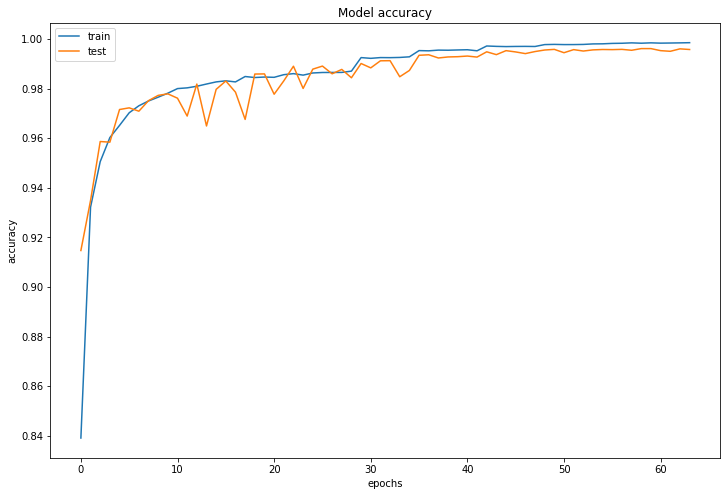

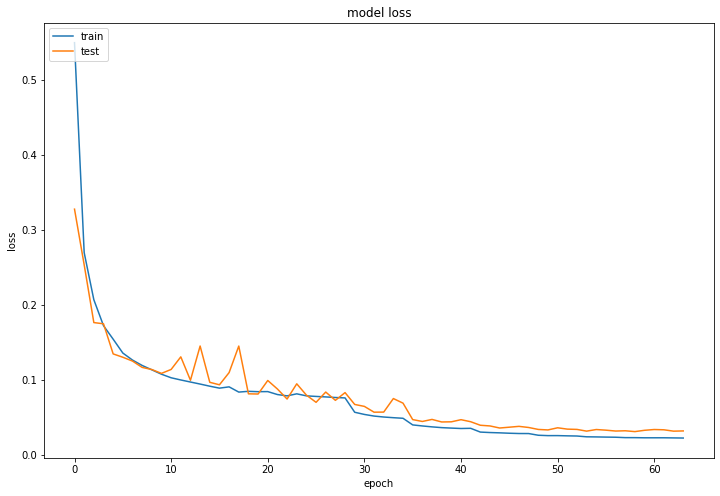

In [13]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(1, figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(2, figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Best model summary 

In [32]:
from keras.models import load_model
model = load_model('model_saver\model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 64)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 92, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 64)            0     

## Accuracy of the model 

In [33]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
import matplotlib as plt 
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.81      0.84       556
           2       0.95      0.96      0.95      1448
           3       0.85      0.82      0.83       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.93      0.91      0.92     21892
weighted avg       0.98      0.98      0.98     21892



## Confusion matrix 

Normalized confusion matrix


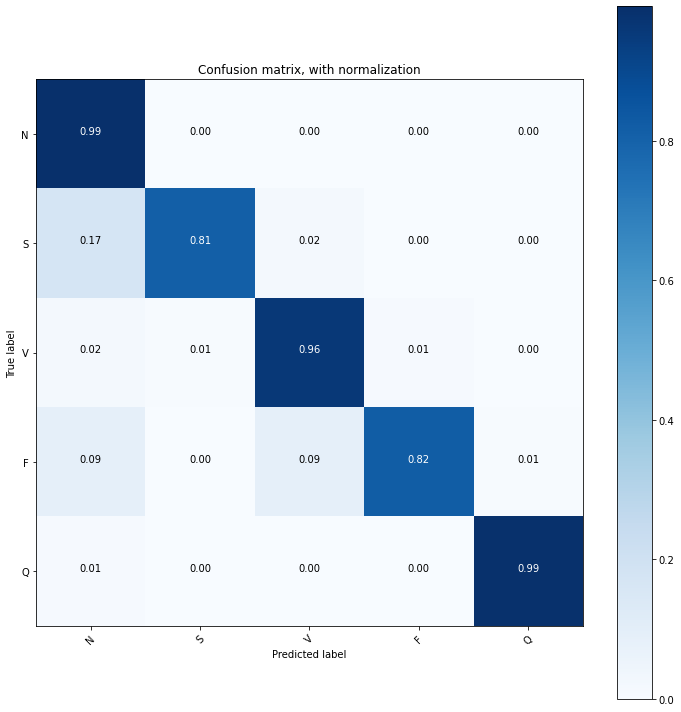

In [35]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()